# Double Wishbone Design Notebook

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib widget

import tomllib as toml

from typing import Collection

import numpy as np

import matplotlib.pyplot as plt

import os, sys 

sys.path.insert(0, os.path.realpath('..'))
from suspension_designer.linkages.double_wishbone import DoubleWishboneBuilder

In [2]:
# %% Test TOML Input
test_input = """
[vehicle]
wheelbase     = 1525      # [mm]
"%_front"     =   47      # [%]     front weight distribution
cg_height     =  225      # [mm]
ride          =   50      # [mm]    ride clearance height
rake          =   +0.30   # [deg]   nose down is positive
loaded_radius =  200      # [mm]    loaded tire radius

[target]
axle        = "f"       # []        front (f), rear (r)
track       = 1220      # [mm] 
"%_roll"    =  +90.00   # [%]       roll-jacking tradeoff
"%_pitch"   =  +95.00   # [%]       pitch-jacking tradeoff
caster      =   +3.00   # [deg]
caster_gain =   +0.05   # [deg/mm] 
camber      =   -1.60   # [deg]
camber_gain =   -0.08   # [deg/mm]
toe         =   +0.50   # [deg]
kpi         =   +5.00   # [deg]     recommended for front axles
scrub       =   +0.00   # [mm]      recommended for rear axles

[bound]     # [mm]
LA  = [[   0   ,   0   ], [ 200.00, 221.00], [  12.50,  12.50]] # [X] y sampled 
LB  = [[   0.00,   0.00], [ -22.00, -22.00], [ -80.00, -70.00]] # [W] all sampled

UA  = [[   0   ,   0   ], [ 221.00, 240.00], [ 175.00, 200.00]] # [X] none sampled
UB  = [[   0.00,   0.00], [ -50.00, -22.00], [  75.00, 100.00]] # [W] x,z sampled

TA  = [[  25.00,  50.00], [ 221.00, 221.00], [  50.00,  75.00]] # [X] x,y sampled
TB  = [[  60.00,  75.00], [ -50.00, -22.00], [ -60.00, -25.00]] # [W] all sampled
"""
        
def convert_number_lists(d: dict) -> dict:
    for k,v in d.items():
        if isinstance(v, dict):
            d[k] = convert_number_lists(v)
        elif not isinstance(v, str) and isinstance(v, Collection):
            try:
                d[k] = np.array(v)
            except:
                continue

    return d

def parse_toml(input_toml: str) -> dict:
    return convert_number_lists(toml.loads(input_toml))

vehicle, target, bound = parse_toml(test_input).values()

In [17]:
# %% Initialize
builder = DoubleWishboneBuilder(vehicle, target, bound)

builder.design_linkage()
suspension = builder.linkage

RIC: [ 808.25       -699.96727548   48.31846508]
PIC: [-1132.79558747   610.            27.01733728]
LA : [813.10478483 210.5        102.38784826]
LB : [811.98306348 584.48210006 124.43880013]
pLA: [813.10478483 210.5        102.38784826]
pTA: [844.822113   221.         128.45026365]
p3 : [823.10478483 210.5        102.38784826]
pickup_line.point: [[  0.         213.0582214  108.73769862]
 [  1.         213.11847414 108.88725403]]
pickup_line.basis: [0.98724947 0.05948448 0.1476485 ]
UA : [829.59130894 263.04336682 232.80756753]
UB : [803.35473007 565.81441489 286.25795802]


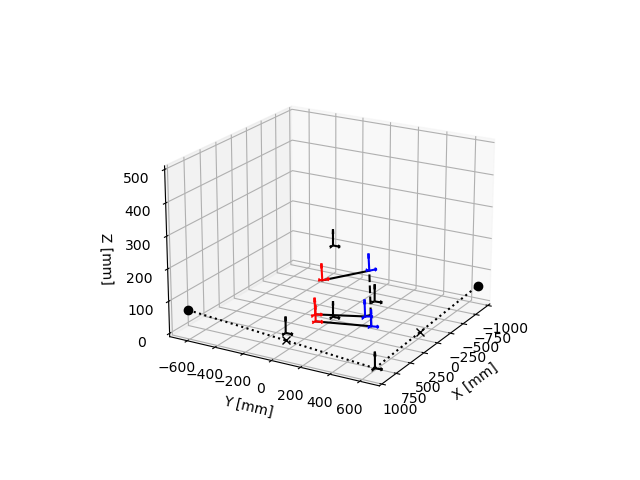

In [18]:
#fig, ax = plt.subplots(1,1)
ax = plt.figure().add_subplot(projection='3d')
builder.linkage.plot()

ax.set_xlim([-1000,1000]);
ax.set_ylim([-700,700]);

In [5]:
builder.linkage.jounce_sweep()

AttributeError: 'DoubleWishbone' object has no attribute 'place_wheel_frame'